In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split
import os
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
from random import seed
from random import randrange
import timeit
import tensorflow as tf
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [25]:
import scoring_alg as sa

In [5]:
SNOMED_scored=pd.read_csv("../../Data/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("../../Data/SNOMED_mappings_unscored.csv", sep=";")

In [6]:
data = pd.read_csv('../../Data/ecg_data_with_labels.csv')

In [7]:
conf_weights = pd.read_csv("../../Data/weights.csv", sep=",", header= 0, index_col=0 )

In [8]:
data.head()

Unnamed: 0    0     1          2           3           4           5  \
0           0  0.0  74.0   0.818758  100.334448   99.009901  102.040816   
1           1  0.0  49.0   1.760567   76.923583   76.142132   81.300813   
2           2  0.0  81.0  37.708984  141.308685   31.120332  185.185185   
3           3  0.0  45.0  25.252184  109.090909   70.754717  153.846154   
4           4  0.0  53.0   6.227148  119.521912  101.694915  144.230769   

            6             7         8  ...         103        104         105  \
0  100.537248  10108.408537  0.017732  ...  100.334448  97.087379  105.263158   
1   77.742365   6046.974958  0.010598  ...   77.519380  75.376884   81.081081   
2  131.051603  18596.490035  0.083807  ...  144.927536  30.895984  227.272727   
3  110.019668  12742.000091  0.182643  ...   91.743119  72.639225  285.714286   
4  120.016109  14442.643773  0.182657  ...  118.812347  84.745763  267.857143   

          106        107         108        109         110         111  \
0  100.470283  14.954241  100.334448  83.102493  128.205128  102.729465   
1   77.848763   2.431188   77.720207  74.812968   82.872928   77.885993   
2  137.312455  58.608281  136.986301  31.023785  272.727273  139.162091   
3  120.996071  61.174821   93.167702  68.181818  285.714286  123.129987   
4  128.928710  47.516386  120.000000  80.862534  256.410256  133.257833   

      labels  
0   59118001  
1  426783006  
2  164889003  
3  164889003  
4  164884008  

[5 rows x 114 columns]

In [9]:
print(np.where(data.iloc[:,:-1].isna()))
print(data.index[np.isinf(data.iloc[:,:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,:-1]).any()])

(array([   10,    10,    10, ..., 42715, 42715, 42715], dtype=int64), array([ 86,  87,  90, ...,  86, 103, 108], dtype=int64))
Int64Index([  632,  3697,  3939,  4014,  4518,  5058,  5679,  5891,  6062,
             8216, 13699, 13724, 19728, 20086, 23641, 23989, 24402, 26278,
            27813, 28736, 29211, 29417, 29893, 32200, 34761, 36265, 37771,
            38037, 38738, 38760, 38789, 38790, 38793, 40416, 42518, 42715],
           dtype='int64')


In [10]:
data.shape

(42720, 114)

In [11]:
data = data.dropna()

In [12]:
#data = data.replace([np.inf, -np.inf], 0)

In [13]:
data.shape

(42574, 114)

About 150 ECG-recordings removed

In [14]:
print(np.where(data.iloc[:,1:-1].isna()))
print(data.index[np.isinf(data.iloc[:,1:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,1:-1]).any()])

(array([], dtype=int64), array([], dtype=int64))
Int64Index([], dtype='int64')


In [15]:
y_data = data['labels']

In [16]:
X_data = data.iloc[:,1:-1]

In [17]:
data.iloc[:,1:]

0     1          2           3           4           5           6  \
0      0.0  74.0   0.818758  100.334448   99.009901  102.040816  100.537248   
1      0.0  49.0   1.760567   76.923583   76.142132   81.300813   77.742365   
2      0.0  81.0  37.708984  141.308685   31.120332  185.185185  131.051603   
3      0.0  45.0  25.252184  109.090909   70.754717  153.846154  110.019668   
4      0.0  53.0   6.227148  119.521912  101.694915  144.230769  120.016109   
...    ...   ...        ...         ...         ...         ...         ...   
42714  0.0  69.0   7.297528   83.857483   43.165468  100.000000   84.698054   
42716  0.0  66.0  15.661281  106.951872   77.821012  162.162162  111.835712   
42717  0.0  75.0  24.199197   74.074074   54.005401  172.910663   82.825268   
42718  0.0  75.0   5.567916   71.770335   60.544904  117.878193   72.181759   
42719  0.0  61.0   8.415853   74.626866   58.939096  132.743363   75.134926   

                  7         8         9  ...         103        104  \
0      10108.408537  0.017732  0.005000  ...  100.334448  97.087379   
1       6046.974958  0.010598  0.509000  ...   77.519380  75.376884   
2      18596.490035  0.083807  0.727000  ...  144.927536  30.895984   
3      12742.000091  0.182643  0.757000  ...   91.743119  72.639225   
4      14442.643773  0.182657  1.633000  ...  118.812347  84.745763   
...             ...       ...       ...  ...         ...        ...   
42714   7227.014241  0.000296  0.001149  ...   84.151473  39.447732   
42716  12752.502188  0.000609  0.001320  ...  106.951872  52.310375   
42717   7445.626183  0.000183  0.000668  ...   74.028406  43.699927   
42718   5241.208078  0.000082  0.000505  ...   71.856287  59.113300   
42719   5716.083762  0.001200  0.002346  ...   72.727380  29.600395   

              105         106         107         108        109         110  \
0      105.263158  100.470283   14.954241  100.334448  83.102493  128.205128   
1       81.081081   77.848763    2.431188   77.720207  74.812968   82.872928   
2      227.272727  137.312455   58.608281  136.986301  31.023785  272.727273   
3      285.714286  120.996071   61.174821   93.167702  68.181818  285.714286   
4      267.857143  128.928710   47.516386  120.000000  80.862534  256.410256   
...           ...         ...         ...         ...        ...         ...   
42714  115.384615   83.865065   11.183673   84.388186  38.961039  118.110236   
42716  674.157303  124.437248  109.953989  106.761566  55.147059  952.380952   
42717  402.684564   87.165430   54.370778   74.580514  42.765502  431.654676   
42718  129.310345   72.224439    8.011272   71.770335  61.855670  144.578313   
42719  223.048327   76.852039   30.662184   73.619632  29.140359  232.558140   

              111     labels  
0      102.729465   59118001  
1       77.885993  426783006  
2      139.162091  164889003  
3      123.129987  164889003  
4      133.257833  164884008  
...           ...        ...  
42714   83.813103  164865005  
42716  131.061693  164865005  
42717   87.921362  164865005  
42718   72.411308  164865005  
42719   78.216127  164865005  

[42574 rows x 113 columns]

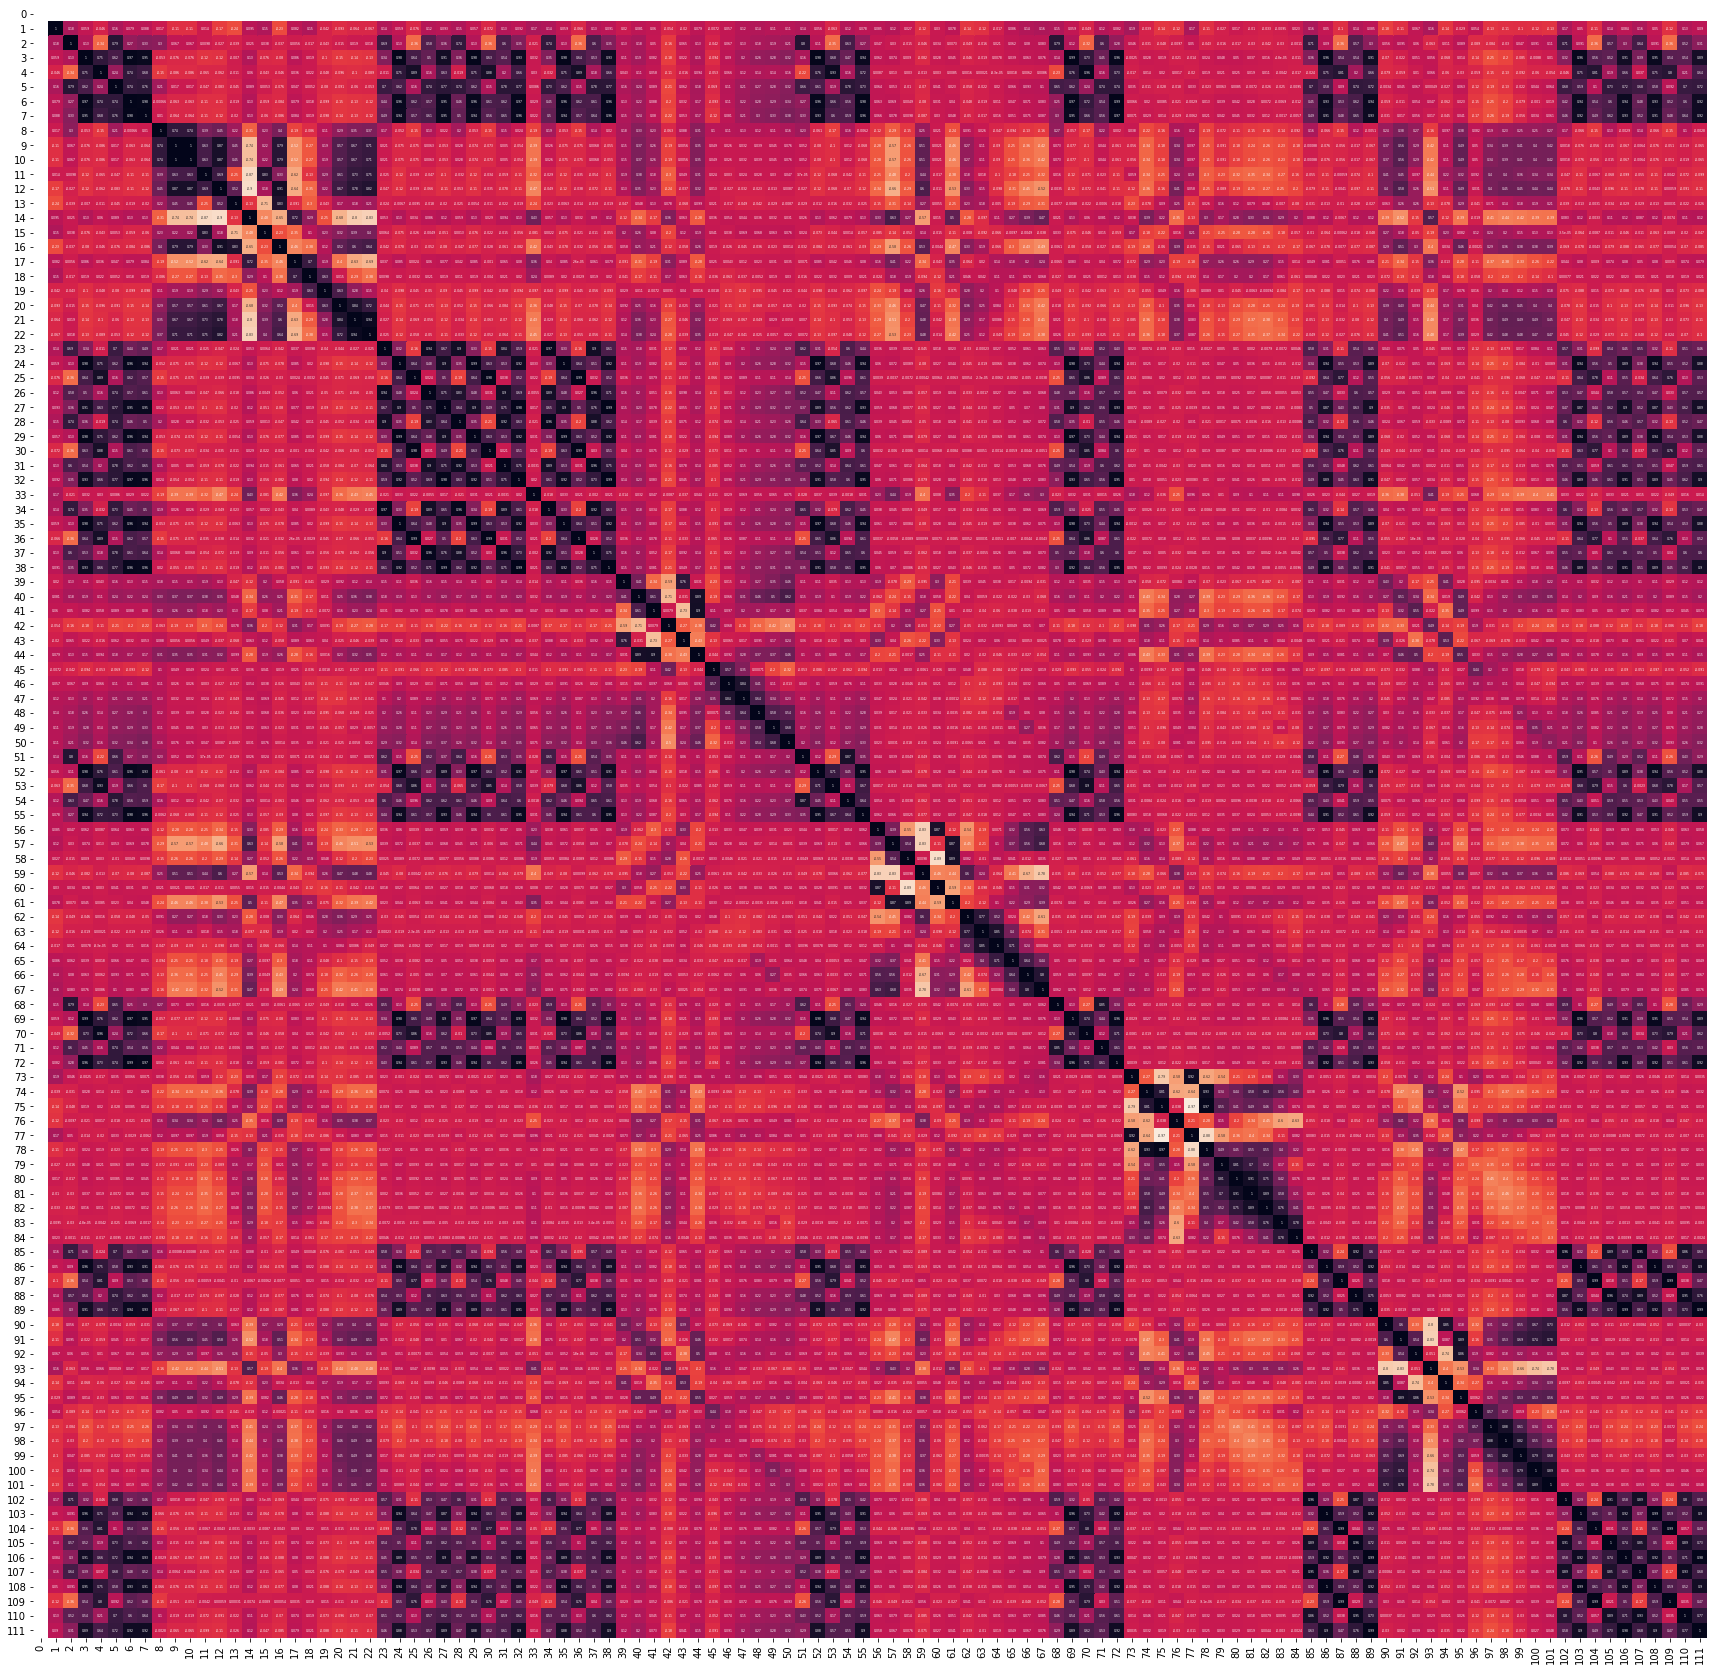

In [18]:
import seaborn as sns
plt.figure(figsize=(30,30))
cor = data.iloc[:,1:].corr()
sns.heatmap(cor, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 3})
plt.show()

In [19]:
def making_undef_class(labels):
    df_labels = pd.DataFrame(labels)
    for i in range(len(SNOMED_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(SNOMED_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)
    return df_labels

  
df_y = making_undef_class(y_data)

In [20]:
y_data.unique()

array(['59118001', '426783006', '164889003', ..., '368009,427084000',
       '698247007,74390002', '164895002,164896001,164865005,164889003'],
      dtype=object)

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
y=one_hot.fit_transform(df_y['labels'].str.split(pat=','))
print(one_hot.classes_)
print("classes: {}".format(y.shape[1]))

['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 28


In [22]:
y = np.delete(y, -1, axis=1)

In [23]:
norsk_liste = ['pacing-rytme', 'forlenget qt-intervall', 'atrieflimmer','atrieflutter','venstre grenblokk','unormal Q-bølge','unormal T-bølge','forlenget PR-intervall', 'ventrikulære premature slag','lav QRS-spenning','1.grads AV-blokk','prematur atriell kontraksjon',
               'venstre akse avvik','sinusbradykardi','bradykardi','sinus rytme', 'sinus takykardi', 'prematur ventrikulær kontraksjon','sinusarytmi','venstre fremre fascikulærblokk','høyre akse avvik','høyre grenblokk','invertert T-bølge','supraventrikulære premature slag',
               'uspesifikk intraventrikulær ledningsforstyrrelse','ufullstendig høyre grenblokk','komplett høyre grenblokk']

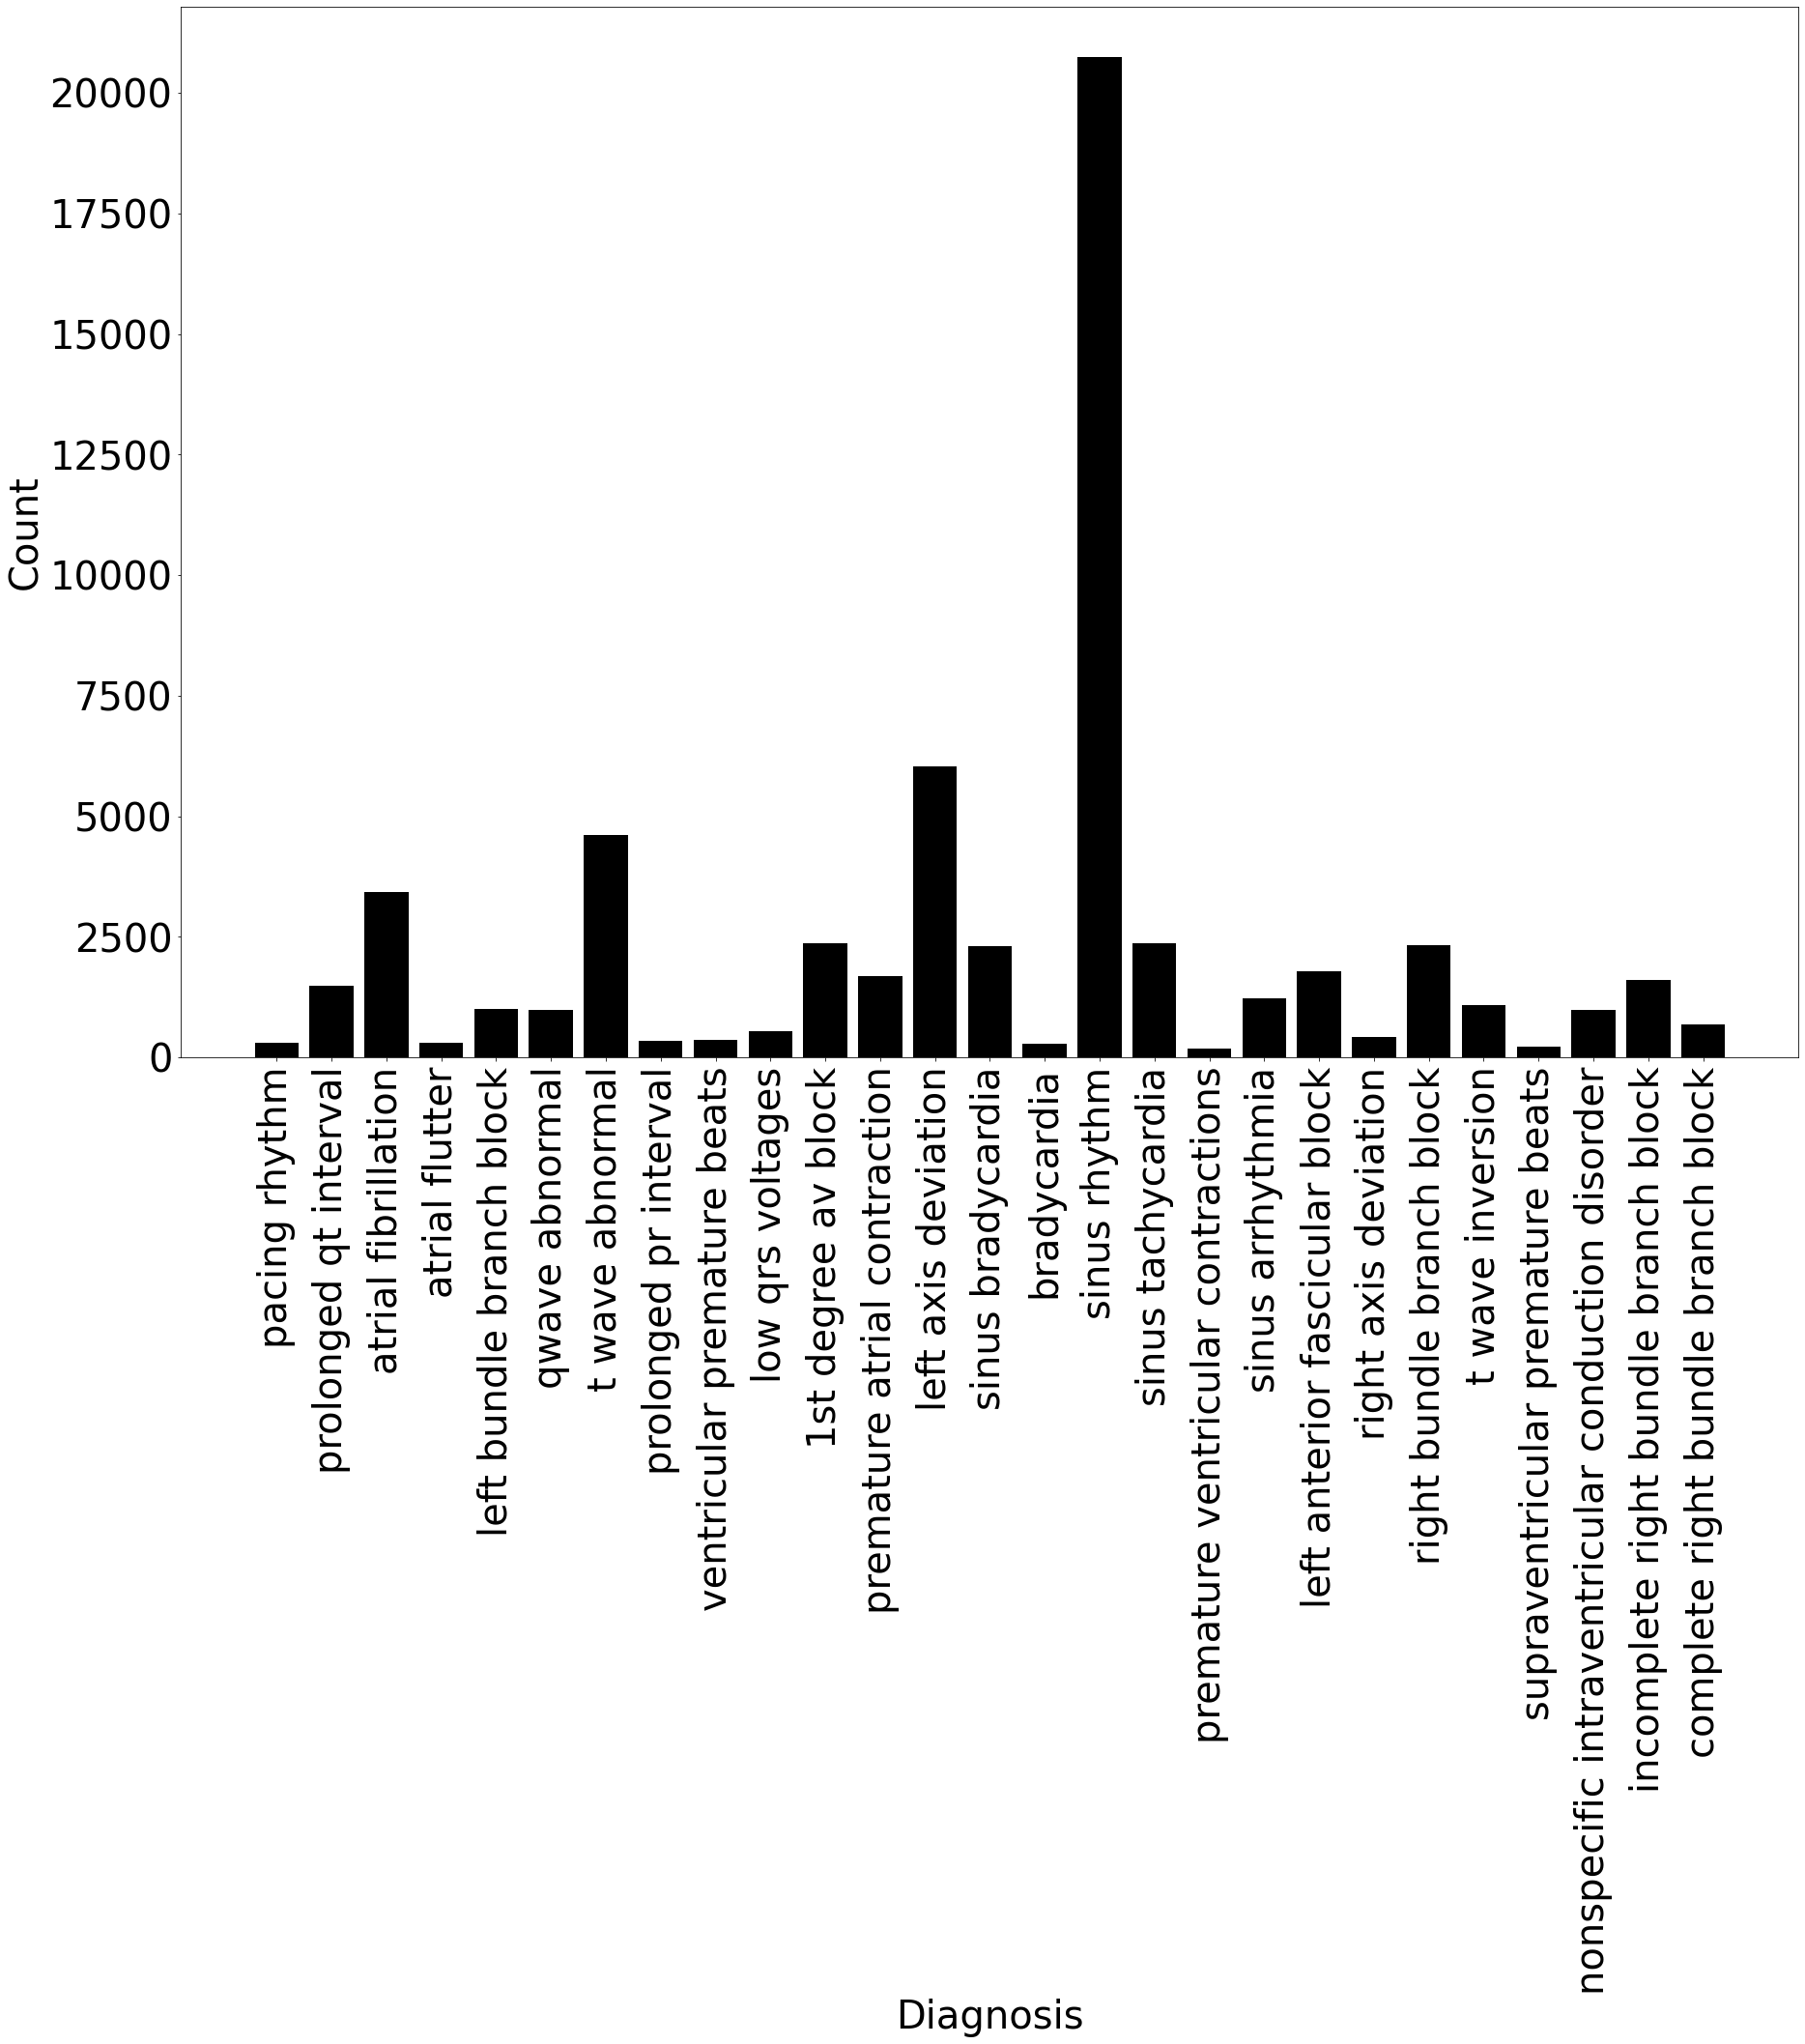

In [26]:
sa.plot_classes(one_hot.classes_[0:-1],SNOMED_scored, y)

In [27]:
#@title Transform our One Hot encoded multilabel output to a new type of label where all can be represented by a number:
from sklearn.preprocessing import LabelEncoder

def get_new_labels(y):
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_new

y_temp_new = get_new_labels(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_temp_new))))

Total number of unique combinations of diagnosis: 1396


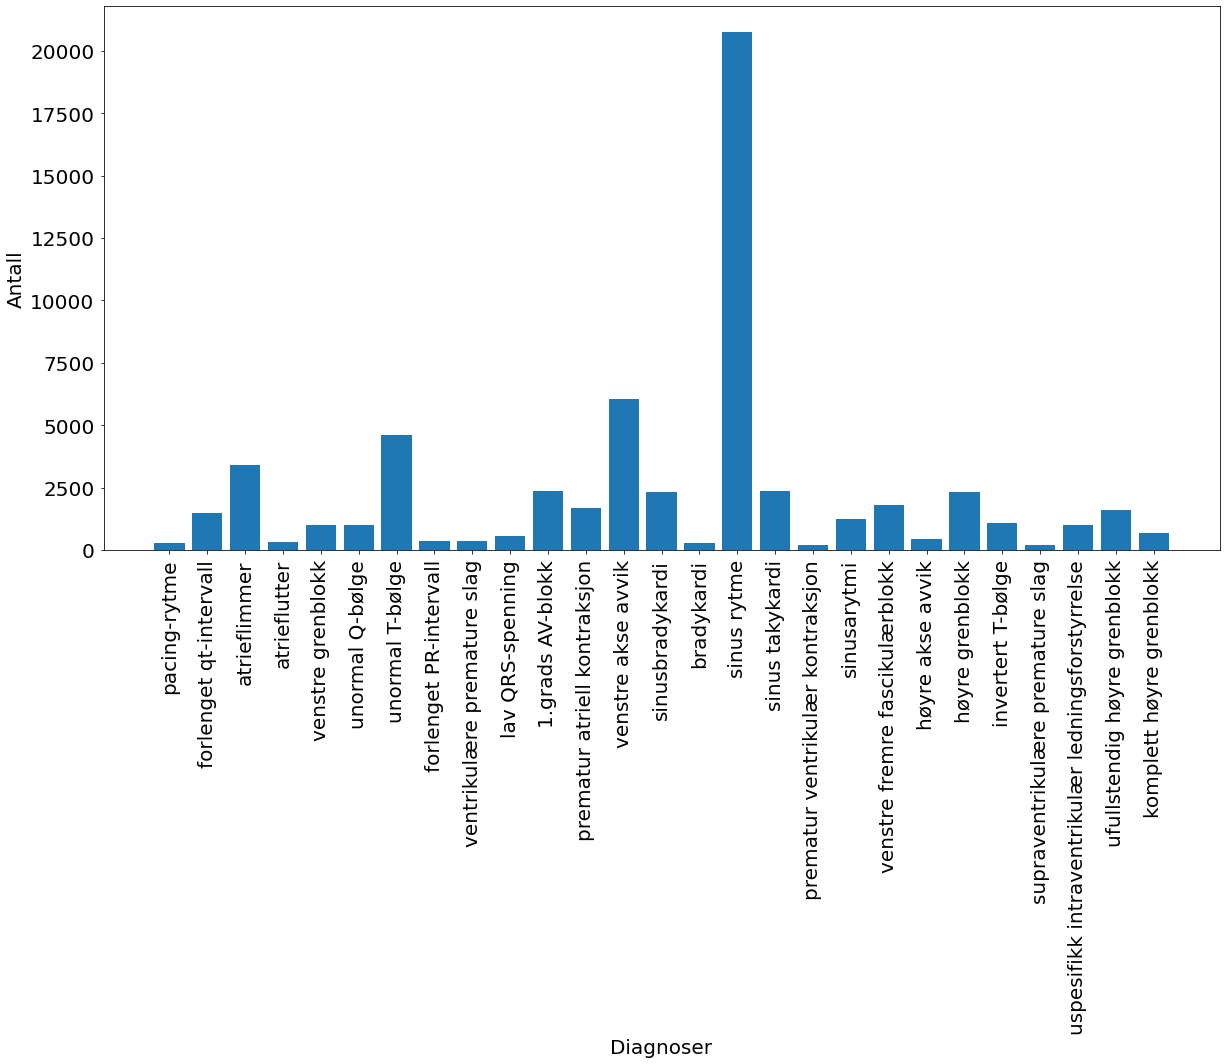

In [28]:
sa.plot_classes_2(one_hot.classes_[0:-1],y,SNOMED_scored,norsk_liste)

In [29]:
one_hot.classes_[0:-1][26]

'complete right bundle branch block'

In [31]:
#@title K-fold, 10 splits, Shuffle=True and random_state = 42. The distribution of Training and Val data in each fold is now:
from sklearn.model_selection import StratifiedKFold
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(y,y_new))
print("Training split: {}".format(len(folds[0][0])))
print("Validation split: {}".format(len(folds[0][1])))

Training split: 38316
Validation split: 4258


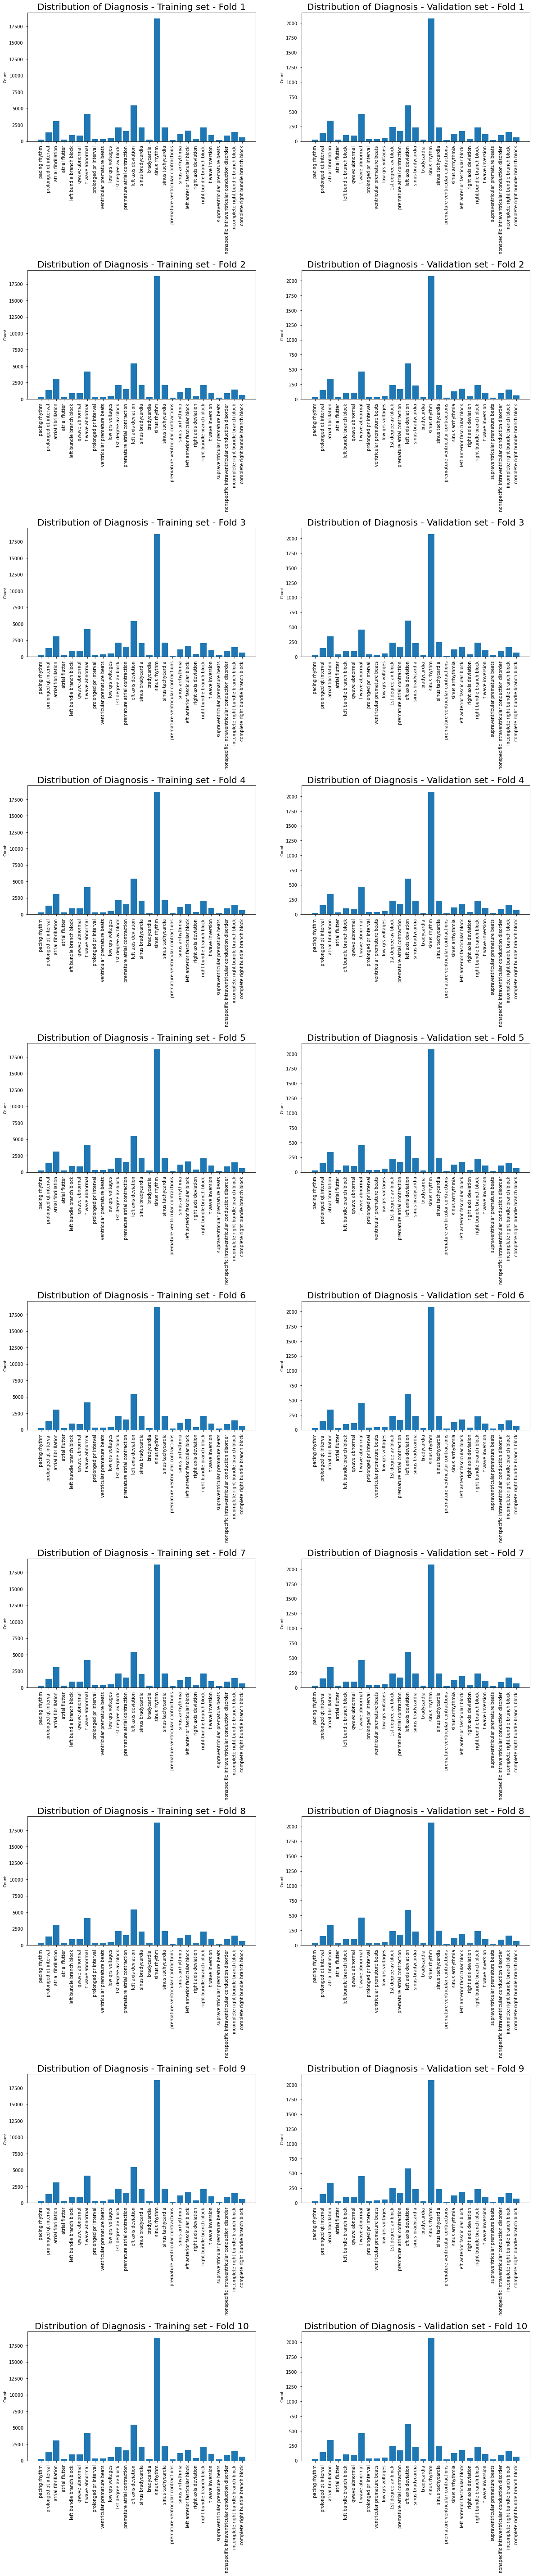

In [32]:
#@title The distribution of diagnosis in each Fold:
X_axis_labels=one_hot.classes_[0:-1]
plt.figure(figsize=(20,100))
h=1
for i in range(len(folds)):
    plt.subplot(10,2,h)
    plt.subplots_adjust(hspace=1.0)
    plt.bar(x= X_axis_labels, height=y[folds[i][0]].sum(axis=0))
    plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1) ,fontsize="20", color = "black")
    plt.tick_params(axis="both", colors = "black")
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize = 10)
    #plt.xlabel("Diagnosis", color = "white")
    plt.ylabel("Count", color = "black")
    h=h+1
    plt.subplot(10,2,h)
    plt.subplots_adjust(hspace=1.0)
    plt.bar(x= X_axis_labels, height=y[folds[i][1]].sum(axis=0))
    plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1) ,fontsize="20", color = "black")
    plt.tick_params(axis="both", colors = "black")
    #plt.xlabel("Diagnosis", color = "white")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize = 10)
    h=h+1

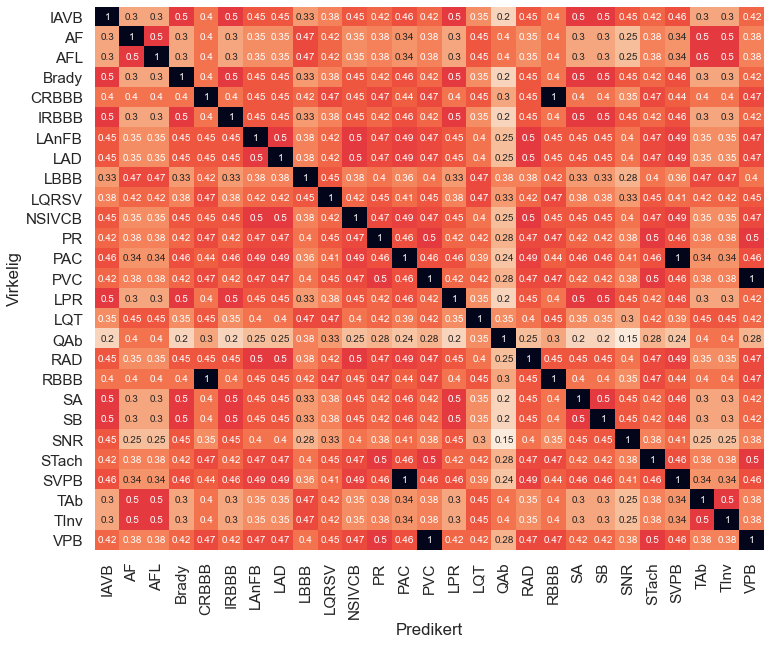

In [33]:
import seaborn as sns
conf_weights.columns = SNOMED_scored.iloc[:,0]
conf_weights.index = SNOMED_scored.iloc[:,0]

conf_weights = pd.DataFrame(conf_weights, columns=SNOMED_scored.iloc[:,0], index = SNOMED_scored.iloc[:,0])

conf_weights.columns=SNOMED_scored.iloc[:,2]
conf_weights.index = SNOMED_scored.iloc[:,2]
conf_weights.index.name = 'Virkelig'
conf_weights.columns.name = 'Predikert'

plt.figure(figsize = (12,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_weights, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 10})# font size
plt.savefig("./confmatrix_weights.png",dpi=200)

In [34]:
my_cluster = []
for i in range(len(y.T)):
    my_cluster.append(np.unique(np.where(y[np.where(y.T[i]==1)])[1]))

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from sklearn.ensemble import RandomForestClassifier

In [40]:
val_res = np.zeros(shape=(5,10))
training_res = np.zeros(shape=(5,10))
j = 0

for train_index, val_index in folds:
    
    X_train, X_val = np.asarray(X_data)[train_index], np.asarray(X_data)[val_index]
    y_train, y_val = y[train_index], y[val_index]


    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    print("Making a cluster")
    my_cluster = []
    for i in range(len(y_train.T)):
        my_cluster.append(np.unique(np.where(y_train[np.where(y_train.T[i]==1)])[1]))
    print("Making the model")
    classifier = LabelSpacePartitioningClassifier(
        classifier = ClassifierChain(
            classifier= RandomForestClassifier(n_jobs=-1,n_estimators=5, verbose=0),
            require_dense = [False, True]
        ),
        require_dense = [True, True],
        clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
    )

    classifier.fit(X_train_scaled,y_train)
    y_pred_val = classifier.predict(X_val_scaled)
    y_pred_train = classifier.predict(X_train_scaled)

    y_pred_val = y_pred_val.todense()
    y_pred_val = np.asarray(y_pred_val)

    y_pred_train = y_pred_train.todense()
    y_pred_train = np.asarray(y_pred_train)

    val_res[0,j] = us.compute_beta_measures(y_val,y_pred_val,2)[0]
    val_res[1,j] = us.compute_beta_measures(y_val,y_pred_val,2)[1]
    val_res[2,j] = us.compute_f_measure(y_val,y_pred_val)
    val_res[3,j] = us.compute_accuracy(y_val,y_pred_val)
    val_res[4,j] = us.compute_challenge_metric_for_opt(y_val,y_pred_val)
    training_res[0,j] = us.compute_beta_measures(y_train,y_pred_train,2)[0]
    training_res[1,j] = us.compute_beta_measures(y_train,y_pred_train,2)[1]
    training_res[2,j] = us.compute_f_measure(y_train,y_pred_train)
    training_res[3,j] = us.compute_accuracy(y_train,y_pred_train)
    training_res[4,j] = us.compute_challenge_metric_for_opt(y_train,y_pred_train)
    j = j+1



    print("{}-fold cross val:".format(j))
    print("F2-score:",us.compute_beta_measures(y_val,y_pred_val,2)[0])
    print("G2-score:",us.compute_beta_measures(y_val,y_pred_val,2)[1])
    print("F-measure:",us.compute_f_measure(y_val,y_pred_val))
    print("Accuracy:",us.compute_accuracy(y_val,y_pred_val))
    print("Challenge prediction:", us.compute_challenge_metric_for_opt(y_val,y_pred_val))
    print("Challenge prediction (train data):", us.compute_challenge_metric_for_opt(y_train,y_pred_train))
    
validerings_resultat = pd.DataFrame(val_res)
trenings_resultat = pd.DataFrame(training_res)
validerings_resultat.to_csv("valideringsresultat_forest_chain_cluster.csv")
trenings_resultat.to_csv("treningsresultat_forest_chain_cluster.csv")

Making a cluster
Making the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurr

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.0s remain

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finish

KeyboardInterrupt: 